# Routes.dat



    Airline --> 2-letter (IATA) or 3-letter (ICAO) code of the airline.
    Airline ID --> Unique OpenFlights identifier for airline (see Airline).
    Source airport --> 3-letter (IATA) or 4-letter (ICAO) code of the source airport.
    Source airport ID --> Unique OpenFlights identifier for source airport (see Airport)
    Destination airport --> 3-letter (IATA) or 4-letter (ICAO) code of the destination airport.
    Destination airport ID --> Unique OpenFlights identifier for destination airport (see Airport)
    Codeshare --> "Y" if this flight is a codeshare (that is, not operated by Airline, but another carrier), empty otherwise.
    Stops --> Number of stops on this flight ("0" for direct)
    Equipment --> 3-letter codes for plane type(s) generally used on this flight, separated by spaces

    The data is UTF-8 encoded. The special value \N is used for "NULL" to indicate that no value is available, and is understood automatically by MySQL if imported.




In [1]:
# routes.dat
!wget https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat

--2022-01-28 23:00:44--  https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2377148 (2.3M) [text/plain]
Saving to: ‘routes.dat.4’

routes.dat.4        100%[===================>]   2.27M  --.-KB/s    in 0.06s   

2022-01-28 23:00:44 (36.5 MB/s) - ‘routes.dat.4’ saved [2377148/2377148]



In [2]:
# whitehouse-waves
!wget https://obamawhitehouse.archives.gov/sites/default/files/disclosures/whitehouse-waves-2014_03.csv_.zip

--2022-01-28 23:00:59--  https://obamawhitehouse.archives.gov/sites/default/files/disclosures/whitehouse-waves-2014_03.csv_.zip
Resolving obamawhitehouse.archives.gov (obamawhitehouse.archives.gov)... 54.230.19.126, 54.230.19.97, 54.230.19.122, ...
Connecting to obamawhitehouse.archives.gov (obamawhitehouse.archives.gov)|54.230.19.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4375560 (4.2M) [application/zip]
Saving to: ‘whitehouse-waves-2014_03.csv_.zip.4’

whitehouse-waves-20 100%[===================>]   4.17M  --.-KB/s    in 0.1s    

2022-01-28 23:00:59 (33.5 MB/s) - ‘whitehouse-waves-2014_03.csv_.zip.4’ saved [4375560/4375560]



In [3]:
!hadoop fs -put routes* /
!hadoop fs -put whitehouse-waves-2014_03.csv_.zip* /

In [7]:
!hdfs dfs -cat /whitehouse-waves-2014_03.csv_.zip | gzip -d | hdfs dfs -put - /whitehouse-waves-2014_03.csv

In [8]:
!hadoop fs -ls /

Found 6 items
-rw-r--r--   2 root hadoop    2377148 2022-01-28 23:01 /routes.dat
drwxrwxrwt   - hdfs hadoop          0 2022-01-27 20:36 /tmp
drwxrwxrwt   - hdfs hadoop          0 2022-01-28 08:00 /user
drwx-wx-wx   - hive hadoop          0 2022-01-27 20:36 /var
-rw-r--r--   2 root hadoop   28134358 2022-01-28 23:02 /whitehouse-waves-2014_03.csv
-rw-r--r--   2 root hadoop    4375560 2022-01-28 23:01 /whitehouse-waves-2014_03.csv_.zip


In [9]:
from pyspark.sql import SparkSession, SQLContext, Row

In [10]:
spark = SparkSession.builder.appName("DataExploring").getOrCreate()
sc = spark.sparkContext

data_file = "hdfs:///routes.dat"

routes = sc.textFile(data_file).cache()

routes.take(5)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


['2B,410,AER,2965,KZN,2990,,0,CR2',
 '2B,410,ASF,2966,KZN,2990,,0,CR2',
 '2B,410,ASF,2966,MRV,2962,,0,CR2',
 '2B,410,CEK,2968,KZN,2990,,0,CR2',
 '2B,410,CEK,2968,OVB,4078,,0,CR2']

In [11]:
routes

hdfs://localhost:8020/routes.dat MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:0

In [12]:
routes_split = routes.map(lambda row : row.split(","))
parsed_routes = routes_split.map(lambda r : Row(
    airline = str(r[0]),
    airline_ID = r[1],
    source_airport = r[2],
    source_airport_ID = r[3],
    destination_airport = r[4],
    destination_airport_ID = r[5],
    codeshare = r[6],
    stops = r[7],
    equipment = r[8]
    )
)

parsed_routes.take(5)

[Row(airline='2B', airline_ID='410', source_airport='AER', source_airport_ID='2965', destination_airport='KZN', destination_airport_ID='2990', codeshare='', stops='0', equipment='CR2'),
 Row(airline='2B', airline_ID='410', source_airport='ASF', source_airport_ID='2966', destination_airport='KZN', destination_airport_ID='2990', codeshare='', stops='0', equipment='CR2'),
 Row(airline='2B', airline_ID='410', source_airport='ASF', source_airport_ID='2966', destination_airport='MRV', destination_airport_ID='2962', codeshare='', stops='0', equipment='CR2'),
 Row(airline='2B', airline_ID='410', source_airport='CEK', source_airport_ID='2968', destination_airport='KZN', destination_airport_ID='2990', codeshare='', stops='0', equipment='CR2'),
 Row(airline='2B', airline_ID='410', source_airport='CEK', source_airport_ID='2968', destination_airport='OVB', destination_airport_ID='4078', codeshare='', stops='0', equipment='CR2')]

In [ ]:
# airline_ID, destination_airport_ID, source_airport_ID

In [13]:
# parse edilmis dat dosyasını dataframe'e cevirme 
sqlContext = SQLContext(sc)
routes_df = sqlContext.createDataFrame(parsed_routes)
routes_df.show(5)

+-------+----------+--------------+-----------------+-------------------+----------------------+---------+-----+---------+
|airline|airline_ID|source_airport|source_airport_ID|destination_airport|destination_airport_ID|codeshare|stops|equipment|
+-------+----------+--------------+-----------------+-------------------+----------------------+---------+-----+---------+
|     2B|       410|           AER|             2965|                KZN|                  2990|         |    0|      CR2|
|     2B|       410|           ASF|             2966|                KZN|                  2990|         |    0|      CR2|
|     2B|       410|           ASF|             2966|                MRV|                  2962|         |    0|      CR2|
|     2B|       410|           CEK|             2968|                KZN|                  2990|         |    0|      CR2|
|     2B|       410|           CEK|             2968|                OVB|                  4078|         |    0|      CR2|
+-------+-------

In [14]:
routes_df.createTempView("routes")

In [15]:
query = spark.sql("""
              SELECT 
                  airline,
                  destination_airport,
                  COUNT(destination_airport) as Total_Destination_Flight
              FROM routes
              GROUP BY destination_airport, airline
              ORDER BY Total_Destination_Flight DESC
              LIMIT 20
              """)
query.show()

+-------+-------------------+------------------------+
|airline|destination_airport|Total_Destination_Flight|
+-------+-------------------+------------------------+
|     TK|                IST|                     219|
|     DL|                ATL|                     209|
|     AA|                DFW|                     181|
|     US|                DFW|                     177|
|     LH|                FRA|                     169|
|     AF|                CDG|                     164|
|     UA|                IAH|                     161|
|     AF|                ATL|                     161|
|     KL|                ATL|                     160|
|     UA|                ORD|                     158|
|     CA|                PEK|                     143|
|     UA|                DEN|                     141|
|     UA|                EWR|                     140|
|     KL|                AMS|                     137|
|     AA|                CLT|                     133|
|     US| 

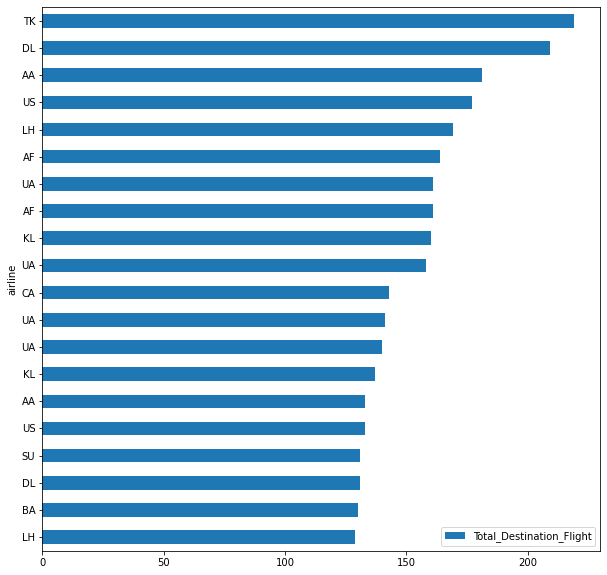

In [16]:
%matplotlib inline
ax = query.sort("Total_Destination_Flight").toPandas().plot.barh(x='airline', figsize=(10,10))

## White House Visitor Records


    UIN - Appointment Number 
    BDG NBR – Badge Number
    Access Type - Type of access to the complex (VA = Visitor Access)
    TOA – Time of Arrival
    POA –  Post of Arrival
    TOD – Time of Departure 
    POD – Post of Departure
    APPT_MADE_DATE – Date the Appointment was made.
    APPT_START_DATE – Date and time for which the appointment was scheduled
    APPT_END_DATE – Date and time for which the appointment was scheduled to end
    APPT_CANCEL_DATE – Date the appointment was canceled, if applicable
    Total_People- The total number of people scheduled for a particular appointment per requestor
    LAST_UPDATEDBY – Identifier of officer that updated record
    POST – Computer used to enter appointment
    LastEntryDate – Most recent update to appointment
    TERMINAL_SUFFIX - Identifier of officer that entered appointment
    visitee_namelast – Last name of the visitee
    visitee_namefirst – First name of the visitee
    MEETING_LOC – Building in which meeting was scheduled
    MEETING_ROOM – Room in which meeting was scheduled
    CALLER_NAME_LAST – Last name of the individual that submitted the WAVES request
    CALLER_NAME_FIRST – First name of the individual that submitted the WAVES request
    CALLER_ROOM – Room from which the appointment was made 
    
    Amac beyaz saraya gelen ziyaretciler en çok kime gelmişler onu bulmak.
    POTUS geçen bir kolon var president of United States kısaltması o kacıncı kolon ise o kolon kime gelindiğini gösteriyor.


In [18]:
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType, DateType

path = "hdfs:///whitehouse-waves-2014_03.csv"

white_house_visitor_record = spark.read.option("header", True).csv(path)
white_house_visitor_record = white_house_visitor_record.withColumn("Total_People", col("Total_People").cast(IntegerType())) \
                             .withColumn("APPT_MADE_DATE", col("APPT_MADE_DATE").cast(DateType())) \
                             .withColumn("APPT_START_DATE", col("APPT_START_DATE").cast(DateType())) \
                             .withColumn("APPT_END_DATE", col("APPT_END_DATE").cast(DateType())) \
                             .withColumn("APPT_CANCEL_DATE", col("APPT_CANCEL_DATE").cast(DateType())) \
                             .withColumn("LASTENTRYDATE", col("LASTENTRYDATE").cast(DateType())) \
                             .withColumn("RELEASE_DATE", col("RELEASE_DATE").cast(DateType()))

white_house_visitor_record.printSchema()

root
 |-- NAMELAST: string (nullable = true)
 |-- NAMEFIRST: string (nullable = true)
 |-- NAMEMID: string (nullable = true)
 |-- UIN: string (nullable = true)
 |-- BDGNBR: string (nullable = true)
 |-- ACCESS_TYPE: string (nullable = true)
 |-- TOA: string (nullable = true)
 |-- POA: string (nullable = true)
 |-- TOD: string (nullable = true)
 |-- POD: string (nullable = true)
 |-- APPT_MADE_DATE: date (nullable = true)
 |-- APPT_START_DATE: date (nullable = true)
 |-- APPT_END_DATE: date (nullable = true)
 |-- APPT_CANCEL_DATE: date (nullable = true)
 |-- Total_People: integer (nullable = true)
 |-- LAST_UPDATEDBY: string (nullable = true)
 |-- POST: string (nullable = true)
 |-- LASTENTRYDATE: date (nullable = true)
 |-- TERMINAL_SUFFIX: string (nullable = true)
 |-- visitee_namelast: string (nullable = true)
 |-- visitee_namefirst: string (nullable = true)
 |-- MEETING_LOC: string (nullable = true)
 |-- MEETING_ROOM: string (nullable = true)
 |-- CALLER_NAME_LAST: string (nullable 

In [19]:
white_house_visitor_record.show(2)

22/01/28 23:04:20 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+---------+-------+------+------+-----------+----+----+----+----+--------------+---------------+-------------+----------------+------------+--------------+----+-------------+---------------+----------------+-----------------+-----------+------------+----------------+-----------------+-----------+-----------+------------+
|NAMELAST|NAMEFIRST|NAMEMID|   UIN|BDGNBR|ACCESS_TYPE| TOA| POA| TOD| POD|APPT_MADE_DATE|APPT_START_DATE|APPT_END_DATE|APPT_CANCEL_DATE|Total_People|LAST_UPDATEDBY|POST|LASTENTRYDATE|TERMINAL_SUFFIX|visitee_namelast|visitee_namefirst|MEETING_LOC|MEETING_ROOM|CALLER_NAME_LAST|CALLER_NAME_FIRST|CALLER_ROOM|description|RELEASE_DATE|
+--------+---------+-------+------+------+-----------+----+----+----+----+--------------+---------------+-------------+----------------+------------+--------------+----+-------------+---------------+----------------+-----------------+-----------+------------+----------------+-----------------+-----------+-----------+------------+
|  A

In [20]:
white_house_visitor_record.createTempView("white_house_visitor")

In [ ]:
# visitee_namefirst --> POTUS

In [21]:
white_house_query = spark.sql("""
                        SELECT 
                            visitee_namefirst ||' '|| visitee_namelast as visite_fullname,
                            COUNT(visitee_namefirst) as Total_Visit
                        FROM white_house_visitor
                        WHERE visitee_namelast != "null" and visitee_namefirst != 'VISITORS'
                        GROUP BY visite_fullname
                        ORDER BY Total_Visit DESC
                        LIMIT 20
                        """)
white_house_query.show()

+----------------+-----------+
| visite_fullname|Total_Visit|
+----------------+-----------+
|   Gene Sperling|        979|
|       Dan Utech|        974|
| Gautam Raghavan|        861|
|       Sam Brown|        779|
|  Melissa Rogers|        758|
|    Rumana Ahmed|        735|
|    John Podesta|        676|
|     J.J. Raynor|        656|
|      Bess Evans|        621|
|   Amy Rosenbaum|        572|
|LADINI JAYARATNE|        565|
|    Allison Hunn|        559|
|  Lynn Rosenthal|        491|
|      Wayne Ting|        471|
|  Heather Foster|        453|
|  Tonya Robinson|        449|
|        Gabe Amo|        421|
|     David Agnew|        414|
|    Ashwani Jain|        408|
|    Nate Perkins|        397|
+----------------+-----------+



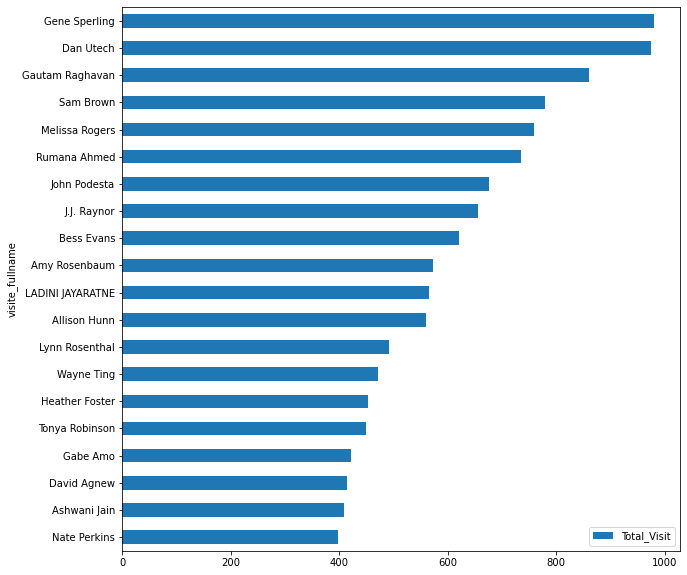

In [22]:
%matplotlib inline
ax = white_house_query.sort("Total_Visit").toPandas().plot.barh(x='visite_fullname', figsize=(10,10))